In [1]:
import re 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from textblob import TextBlob 

import matplotlib.pyplot as plt

import pandas as pd

import os
from better_profanity import profanity
import yake

ModuleNotFoundError: No module named 'tensorflow'

In [14]:
def getSentiment(data_frame):
        data_frame_list=data_frame['tweet_text_element'].to_list()
        
        cleaned_data_frame=[clean(tweet) for tweet in data_frame_list]
        
        data_frame_objects=[TextBlob(tweet) for tweet in cleaned_data_frame]

        sentiment_data_frame = [[tweet.sentiment.polarity, str(tweet)] for tweet in data_frame_objects]
      
        sentiment_df_data_frame = pd.DataFrame(sentiment_data_frame, columns=["polarity", "tweet"])
      
        conditions =[(sentiment_df_data_frame['polarity'] >0.2),(sentiment_df_data_frame['polarity'] <0.1)]
        choices = ['Positive', 'Negative']
        sentiment_df_data_frame['sentiment'] = np.select(conditions, choices)
        data_frame_pos=0
        if "Positive" in sentiment_df_data_frame['sentiment'].values:
            data_frame_pos=sentiment_df_data_frame['sentiment'].value_counts()['Positive']
        data_frame_neg=0
        if "Negative" in sentiment_df_data_frame['sentiment'].values:
            data_frame_neg=sentiment_df_data_frame['sentiment'].value_counts()['Negative']
       
        data_frame_data={
            'sentiment':['Positive',
            'Negative'],'count':[data_frame_pos,data_frame_neg]
        }
        data_frame_data=pd.DataFrame(data_frame_data)    
        return data_frame_data

def clean(tweet):
    if(type(tweet)==float):
        return ""
    r=tweet.lower()
    r=profanity.censor(r)
    r = re.sub("", "", r) #This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

In [29]:
def getNormalized(brand,b_dir):
    b_df=pd.DataFrame(columns=["positive","negative"])
    for i in b_dir:
        if i.endswith(".csv"):
            data=pd.read_csv(brand+"/"+i)
        else:
            continue
        sentiments=getSentiment(data)
        name=i
        curr_df=name.replace(".csv","")
        pos=sentiments.iloc[0]['count']
        neg=sentiments.iloc[1]['count']
        
        b_df.loc[len(b_df.index)] =[pos,neg]
    scaler=MinMaxScaler(feature_range=(0,1),copy=False)
    b_df=scaler.fit_transform(b_df)
    print(b_df)
    return b_df

In [31]:
b1_dir=os.listdir("Samsung")
b2_dir=os.listdir("Apple")
b1_df=getNormalized("Samsung",b1_dir)
b2_df=getNormalized("Apple",b2_dir)


[[0.33333333 0.22105263]
 [0.83333333 0.21052632]
 [0.5        0.07368421]
 [0.2962963  0.17894737]
 [0.09259259 0.16842105]
 [1.         1.        ]
 [0.2037037  0.17894737]
 [0.         0.11578947]
 [0.64814815 0.10526316]
 [0.96296296 0.6       ]
 [0.18518519 0.17894737]
 [0.46296296 0.15789474]
 [0.31481481 0.14736842]
 [0.94444444 0.96842105]
 [0.12962963 0.13684211]
 [0.14814815 0.38947368]
 [0.38888889 0.10526316]
 [0.7962963  0.92631579]
 [0.2037037  0.21052632]
 [0.46296296 0.        ]
 [0.5        0.14736842]
 [0.11111111 0.54736842]
 [0.2962963  0.15789474]
 [0.09259259 0.12631579]
 [0.24074074 0.09473684]
 [0.22222222 0.16842105]
 [0.33333333 0.12631579]
 [0.31481481 0.18947368]
 [0.2962963  0.02105263]
 [0.22222222 0.2       ]
 [0.16666667 0.22105263]
 [0.59259259 0.08421053]
 [0.18518519 0.10526316]
 [0.16666667 0.26315789]
 [0.33333333 0.11578947]
 [0.16666667 0.29473684]
 [0.18518519 0.09473684]
 [0.         0.23157895]
 [0.44444444 0.21052632]
 [0.27777778 0.49473684]


In [169]:
model=Sequential()
model.add(LSTM(units=128,input_shape=(2,4)))
model.add(Dense(units=64))
model.add(Dense(units=32))
model.add(Dense(units=16))
model.add(Dense(units=1, activation='sigmoid')) 
model.compile(loss="mse",optimizer="adam")

In [170]:
b1_df=pd.DataFrame(b1_df,columns=["brand_a_pos","brand_a_neg"])
b2_df=pd.DataFrame(b2_df,columns=["brand_b_pos","brand_b_neg"])

In [171]:
df_merged = pd.concat([b1_df, b2_df], axis=1)
df_merged

,brand_a_pos,brand_a_neg,brand_b_pos,brand_b_neg
0,0.333333,0.221053,0.283951,0.120567
1,0.833333,0.210526,0.382716,0.269504
2,0.500000,0.073684,0.246914,0.156028
3,0.296296,0.178947,0.246914,0.163121
4,0.092593,0.168421,0.123457,0.170213
5,1.000000,1.000000,0.740741,0.929078
6,0.203704,0.178947,0.370370,0.078014
7,0.000000,0.115789,0.259259,0.092199
8,0.648148,0.105263,0.222222,0.156028
9,0.962963,0.600000,1.000000,1.000000


In [172]:
target=df_merged["brand_a_pos"]
df_merged=df_merged.to_numpy()
target=target.to_numpy()
df_merged

array([[0.33333333, 0.22105263, 0.28395062, 0.12056738],
       [0.83333333, 0.21052632, 0.38271605, 0.26950355],
       [0.5       , 0.07368421, 0.24691358, 0.15602837],
       [0.2962963 , 0.17894737, 0.24691358, 0.16312057],
       [0.09259259, 0.16842105, 0.12345679, 0.17021277],
       [1.        , 1.        , 0.74074074, 0.92907801],
       [0.2037037 , 0.17894737, 0.37037037, 0.07801418],
       [0.        , 0.11578947, 0.25925926, 0.09219858],
       [0.64814815, 0.10526316, 0.22222222, 0.15602837],
       [0.96296296, 0.6       , 1.        , 1.        ],
       [0.18518519, 0.17894737, 0.13580247, 0.15602837],
       [0.46296296, 0.15789474, 0.22222222, 0.14893617],
       [0.31481481, 0.14736842, 0.18518519, 0.18439716],
       [0.94444444, 0.96842105, 0.24691358, 0.        ],
       [0.12962963, 0.13684211, 0.11111111, 0.09929078],
       [0.14814815, 0.38947368, 0.0617284 , 0.06382979],
       [0.38888889, 0.10526316, 0.0617284 , 0.29787234],
       [0.7962963 , 0.92631579,

In [173]:
target=np.reshape(target,(51,1))
target

array([[0.33333333],
       [0.83333333],
       [0.5       ],
       [0.2962963 ],
       [0.09259259],
       [1.        ],
       [0.2037037 ],
       [0.        ],
       [0.64814815],
       [0.96296296],
       [0.18518519],
       [0.46296296],
       [0.31481481],
       [0.94444444],
       [0.12962963],
       [0.14814815],
       [0.38888889],
       [0.7962963 ],
       [0.2037037 ],
       [0.46296296],
       [0.5       ],
       [0.11111111],
       [0.2962963 ],
       [0.09259259],
       [0.24074074],
       [0.22222222],
       [0.33333333],
       [0.31481481],
       [0.2962963 ],
       [0.22222222],
       [0.16666667],
       [0.59259259],
       [0.18518519],
       [0.16666667],
       [0.33333333],
       [0.16666667],
       [0.18518519],
       [0.        ],
       [0.44444444],
       [0.27777778],
       [0.5       ],
       [0.44444444],
       [0.09259259],
       [0.16666667],
       [0.11111111],
       [0.44444444],
       [0.11111111],
       [0.   

In [174]:
x_train,x_test,y_train,y_test=train_test_split(df_merged,target,test_size=0.2,random_state=42)

x_test.shape

(11, 4)

In [175]:
x_test=np.delete(x_test,(0),axis=0)
y_test=np.delete(y_test,(0),axis=0)

In [176]:
x_test.shape

(10, 4)

In [177]:
x_train=np.reshape(x_train,(20,2,4))
x_test=np.reshape(x_test,(5,2,4))
y_train=np.reshape(y_train,(20,2))
y_test=np.reshape(y_test,(5,2))

In [179]:
y_train.shape
model_train=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test))

Epoch 1/500
1/1 [==============================] - 0s 82ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 2/500
1/1 [==============================] - 0s 44ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 4/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 5/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 6/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 7/500
1/1 [==============================] - 0s 41ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 8/500
1/1 [==============================] - 0s 42ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 9/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 10/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 11/500
1/1 [=

In [180]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128)               68096     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 78977 (308.50 KB)
Trainable params: 78977 (308.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 18ms/step


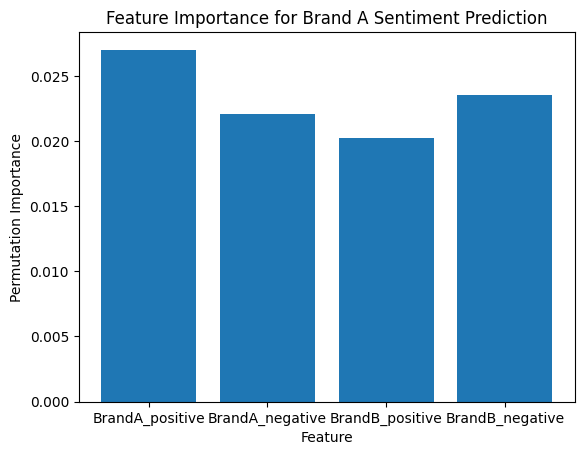

1/1 [==============================] - 0s 24ms/step


In [194]:
# import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle  # For permutation importance
from tensorflow.keras.models import Model  # Assuming you use TensorFlow/Keras

# Load your pre-trained LSTM model (replace 'sequential_3' with your model name)
model = Model(inputs=model.input, outputs=model.output)

# Function to calculate permutation importance for a feature
def permutation_importance(feature_index, X, y, model):
  # Copy the data
  data = X.copy()
  # Shuffle the chosen feature for all data points
  data[:, 1] = shuffle(data[:, 1])
  # Predict with shuffled data
  y_pred_shuffled = model.predict(data)
  # Calculate performance difference (e.g., mean squared error difference)
  performance_difference = np.mean((y - y_pred_shuffled)**2) - np.mean((y - model.predict(X))**2)
  return performance_difference

# Feature names
feature_names = ["BrandA_positive", "BrandA_negative", "BrandB_positive", "BrandB_negative"]

# Calculate permutation importance for each feature
importance = []
for i in range(len(feature_names)):
  importance.append(permutation_importance(i, x_train, y_train, model))

# Visualize feature importance (bar chart)
plt.bar(feature_names, importance)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Feature Importance for Brand A Sentiment Prediction")
plt.show()
